# Data Science Challenge
-----------------------

## [ Part. 2 ] Model Training

## 4. Train / Test Split

## 5. Feature Selection

## 6. Model Selection

## 7. Model Training

## 8. Evaluation

## 9. To-Do

In [1]:
%load_ext autoreload
%autoreload 2

In [75]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from source.utils import plot_precision_recall_curve
from source.utils import plot_feature_selection
from source.utils import get_confusion_matrix
from random import shuffle

pd.options.display.max_columns = 50

%matplotlib inline

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


#### Load feature engineered data

In [3]:
data = pd.read_parquet('./data/events.parquet')

#### Set target values as binary 


In [4]:
data['event_type'] = data['event_type'].map({'search':0,'book':1})

#### Encode 'origin' and 'destination' as numerical categories

In [5]:
origin_dic = {}
for idx, item in enumerate(data['origin'].unique()):
    origin_dic[item] = idx
destin_dic = {}
for idx, item in enumerate(data['destination'].unique()):
    destin_dic[item] = idx
data['origin'] = data['origin'].map(origin_dic)
data['destination'] = data['destination'].map(destin_dic)

#### Change the category value type

In [6]:
category_columns=['origin', 'destination', 'ts_dow', 'date_from_dow', 'date_to_dow']
for col in category_columns:
    data[col] = data[col].astype('category')

## 4. Train / Test Split

In [7]:
data['event_type'].value_counts()

0    45177
1     1808
Name: event_type, dtype: int64

In [8]:
book_userid = list(data[data['event_type']==1]['user_id'].unique())
search_userid = list(set(data['user_id'].unique())-set(book_userid))

In [9]:
print (len(book_userid), len(search_userid))

1804 29361


In [10]:
book_data = data[data['user_id'].isin(book_userid)]
search_data = data[data['user_id'].isin(search_userid)]
book_data.shape, search_data.shape

((9486, 20), (37499, 20))

In [11]:
len(book_data) / ( len(book_data) + len(search_data) )

0.20189422156007236

In [12]:
len(book_userid) / ( len(book_userid) + len(search_userid) )

0.057885448419701585

##### [ Comments ] 
A. Target value is highly imbalanced. (1808 / 45177) 3.8% <br>
B. The ratio of booked users / searched users is slightly better than the target value ratio. (1804 / 29361) 5.7%<br>
C. Activity ratio of booked users / searched users is much better. (9486 / 37499) 20.2%<br>

------------------

#### Train / Test Split should have the similar distribution 

##### 1) Select randomly booked user in 20% and searched users in 20% as Test user 
##### 2) Split Train / Test data based on train / test userid 


In [13]:
train_data_ratio = 0.8
shuffle(book_userid)
shuffle(search_userid)

idx_book = int(len(book_userid)*0.8)
idx_serach = int(len(search_userid)*0.8)

train_user = book_userid[:idx_book] + search_userid[:idx_serach]
test_user = book_userid[idx_book:] + search_userid[idx_serach:]

train_data = data[data['user_id'].isin(train_user)]
test_data = data[data['user_id'].isin(test_user)]
len(train_data), len(test_data)

(37682, 9303)

Set the target value for each datasets 

In [14]:
select_features = ['origin', 'destination','num_adults', 'num_children', 
                  'act_count', 'diff_ts','ts_dow', 'date_from_dow', 
                  'date_to_dow', 'hours_ts', 'ts_day','date_from_day', 
                  'date_to_day', 'trip_duration', 'trip_distance']
target_features = ['event_type']

In [15]:
train_data.head(2)

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,act_count,diff_ts,ts_dow,date_from_dow,date_to_dow,hours_ts,ts_day,date_from_day,date_to_day,trip_duration,trip_distance
0,2017-04-29 17:59:51,0,000069,2017-05-10,2017-05-26,0,0,2,3,1,0.0,5,2,4,17,29,10,26,16,1553.715579
1,2017-04-28 19:14:23,0,00019d,2017-09-15,2017-10-13,1,1,4,0,1,0.0,4,4,4,19,28,15,13,28,1553.715579


In [67]:
X_train = train_data[select_features]
X_test = test_data[select_features]
y_train = train_data[target_features]
y_test = test_data[target_features]


## 5. Feature Selection
--------------------------
Select important features using tree based classfier 

In [19]:

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

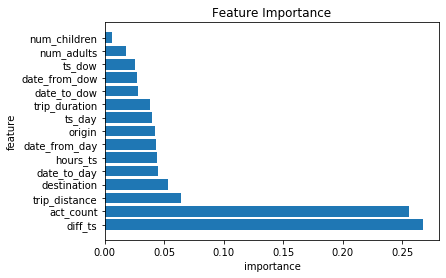

In [20]:
features = plot_feature_selection(clf, X_train.columns)

In [21]:
features[:3]

,feature,importance
5,diff_ts,0.267807
4,act_count,0.255858
14,trip_distance,0.063839


##### [ Comments ]
3 important features for decision are<br> 

##### [1] 'diff_ts' - time difference between actions for unique user
##### [2] 'act_count' - number of activity for each unique users
##### [3] 'trip_distance' - Trip distance between origin in destination in km

In [22]:
clf.score(X_test, y_test)

0.9687197678168333

In [23]:
y_score = clf.predict(X_test)

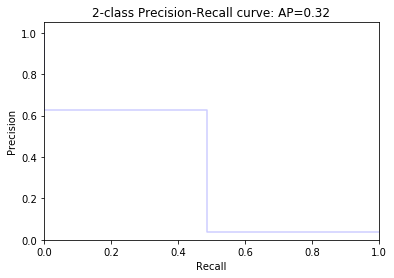

In [24]:
plot_precision_recall_curve(y_test, y_score)

##### [ Comments ]
Target data is highly imbalanced, so precision-recall curve is used for metric

## 6. Model Selection
-----------------------
Using cross_val_score 

In [31]:
classifiers = []
classifiers.append(DecisionTreeClassifier(random_state=42))
classifiers.append(RandomForestClassifier(n_estimators=100, random_state=42))
classifiers.append(GradientBoostingClassifier(n_estimators=100, random_state=42))

kfold = StratifiedKFold(n_splits=5)
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, \
                      X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [35]:
cv_res = pd.DataFrame({"CrossVal_Score_Means":cv_means,"CrossVal_STD": cv_std,\
                       "Model":["DecisionTree", "RandomForest","GradientBoosting"]})

In [41]:
cv_res

,CrossVal_Score_Means,CrossVal_STD,Model
0,0.956611,0.001405,DecisionTree
1,0.970543,0.001858,RandomForest
2,0.969933,0.001476,GradientBoosting


##### [ Comments ]
RandomForest Classifier is best score for training datasets<br> 


## 7. Model Training
-----------------------
Using GridSearchCV

In [42]:

clf = RandomForestClassifier(max_features='sqrt', random_state=42)
kfold = StratifiedKFold(n_splits=5)

parameter_grid = {
             'max_depth' : [5,7,9],
             'max_features': [3, 5, 7, 10, 15],
             'n_estimators': [100,200],
             'criterion': ['gini','entropy']
             }

grid = GridSearchCV(clf, parameter_grid, \
                    cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1 )

grid.fit(X_train, y_train)

print (grid.best_params_)
print (grid.best_score_)
print (grid.score(X_test, y_test))


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  6.2min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed: 10.2min finished


{'criterion': 'gini', 'max_depth': 9, 'max_features': 7, 'n_estimators': 100}
0.9709675707234223
0.9699021820917983


In [94]:
params = {
    'max_depth' : 9,
    'max_features': 7,
    'n_estimators': 100,
    'criterion': 'gini'
}
clf = RandomForestClassifier(max_features='sqrt', random_state=42)
clf.set_params(**params)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9699021820917983

,feature,importance
4,act_count,0.391384
5,diff_ts,0.385863
14,trip_distance,0.033221
1,destination,0.024717
10,ts_day,0.021877


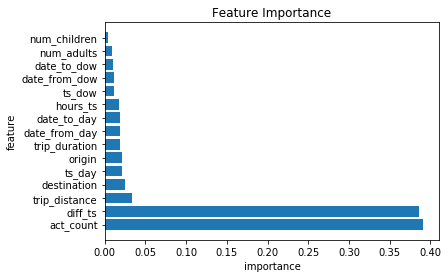

In [98]:
plot_feature_selection(clf, X_test.columns)[:5]

## 8. Evaluation
-----------------------

#### Test Accuracy 

In [78]:
print (grid.score(X_test, y_test))

0.9699021820917983


#### Plot precision - recall curve

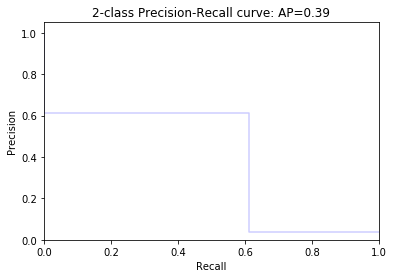

In [69]:

y_score = grid.predict(X_test)
plot_precision_recall_curve(y_test, y_score)

In [79]:
cfm = get_confusion_matrix(y_target, y_score, labels=['search', 'book'])
cfm 

,Predict search,Predict book
search,8801,140
book,140,222


## 9. To-Do
-----------------------

##### (1) If I could know user's attribute and historical activities, I could add that for user-attribute features.
##### (2) If I could know the user's location(like Country), then I could add the holiday information for 'Origin' or 'Destination'
##### (3) Under sampling can be used for imbalanced datasets